# Notebook to clean reference data

## Notebook description

This notebook is used to clean two data sets which will be used as reference in order to make distance/similarity measurements.
Both time series were collected during the same night on the same bed&person but with two different sensors.
Therefore the time series should be as similar as one can get. However there are some differences regarding noise to be expected.

The cleaning will start by cropping both datasets to the same length. Afterwards follows a down-sampling on the data.

## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import math
from functools import reduce
sns.set()
%matplotlib inline
import os

### GLOBALS

In [2]:
REF_PATH_RAW = 'data/raw/reference/'
REF_PATH_CLEAN = 'data/cleaned/reference/'
IMAGES_DIR = 'images/reference/'
THRESHOLD = 500


In [186]:
%ll data/raw/reference

total 16440
-rw-r--r--  1 yannis  staff  4212817 Oct 13 13:02 sleepo_2020-10-11_to_2020-10-12_xxxxx.csv
-rw-r--r--  1 yannis  staff  4200325 Oct 13 13:03 sleepo_2020-10-11_to_2020-10-12_yyyyy.csv


## Read Data

In [3]:
df1 = pd.read_csv(REF_PATH_RAW + 'sleepo_2020-10-11_to_2020-10-12_xxxxx.csv')
df2 = pd.read_csv(REF_PATH_RAW + 'sleepo_2020-10-11_to_2020-10-12_yyyyy.csv')


df1.set_index('id', inplace=True)
df1.sort_index(inplace=True)

df2.set_index('id', inplace=True)
df2.sort_index(inplace=True)

# Data Cleaning

Combine the date, hour, minute and second fields to a date-time

In [4]:
def create_time_stamp(row):
    # '2020-04-06T09:03:51+0000'
    seconds = int(row['second'])
    minutes = int(row['minute'])
    hours = int(row['hour'])
    date = row['date']  # 2020-09-09
    
    ts_str = f"{date}T{hours}:{minutes}:{seconds}+0000"
    ts_obj = datetime.datetime.strptime(ts_str, '%Y-%m-%dT%H:%M:%S%z')
    return ts_obj

# Create Timestamps
df1['timestamp'] = df1.apply(lambda row: create_time_stamp(row), axis=1)
df2['timestamp'] = df2.apply(lambda row: create_time_stamp(row), axis=1)

## Deal with dublicated values

Number of duplicated timestamps:

In [5]:
print(f"Number of duplicated timestamps in df1: {df1.timestamp.duplicated().sum()}")
print(f"Number of duplicated timestamps in df2: {df2.timestamp.duplicated().sum()}")

Number of duplicated timestamps in df1: 118
Number of duplicated timestamps in df2: 295


There are 118 pairs of duplicates in df1 and 295 pairs of duplicates in df2

Create DataFrames only containing the duplicates

In [6]:
duplicates1 = pd.concat(g for _, g in df1.groupby("timestamp") if len(g) > 1)
duplicates2 = pd.concat(g for _, g in df2.groupby("timestamp") if len(g) > 1)

Display the distribution of duplicates in df1

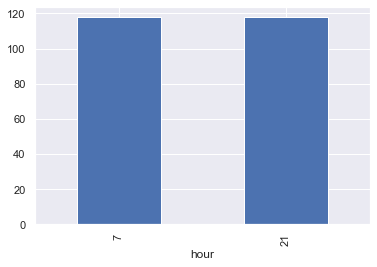

In [7]:
duplicates1.groupby("hour").count()['timestamp'].plot(kind='bar')

Display the distribution of duplicates in df2

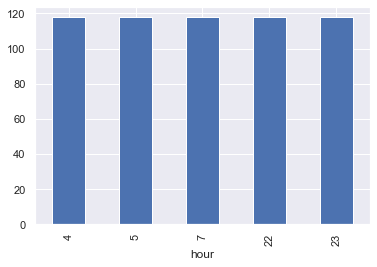

In [8]:
duplicates2.groupby("hour").count()['timestamp'].plot(kind='bar')

Drop duplicates, but keep first value

In [9]:
df1.drop_duplicates(subset=["timestamp"], keep='first', inplace=True)
df2.drop_duplicates(subset=["timestamp"], keep='first', inplace=True)

Ensure there are no duplicates anymore

In [10]:
print(f"Number of duplicated timestamps in df1: {df1.timestamp.duplicated().sum()}")
print(f"Number of duplicated timestamps in df2: {df2.timestamp.duplicated().sum()}")

Number of duplicated timestamps in df1: 0
Number of duplicated timestamps in df2: 0


## Change index

In [11]:
try:
    df1.set_index('timestamp', inplace=True)
except KeyError:
    pass
try:
    df2.set_index('timestamp', inplace=True)
except KeyError:
    pass

In [12]:
df1.sort_index(inplace=True)
df2.sort_index(inplace=True)

# Replace missing values

First of all we want to make sure, that our reference time series both start at the same time and have a value for every second.

## Crop to the same length

The reference time series are recorded from 8:00 PM to 10:00 AM.
The sampling granularity is one second. However due to the sensors behaviour, some data points are missing every 30s.
Due to the fine granularity this is negligible.
Most often the first few 1000 measures of these time series are 0 (the bed is not yet occupied). Therefore we will crop them at the beginning and end to have the same start and endpoint.

If data would be sent every second wihout missing data, each time series would be $14\cdot3600 = 50400$ rows long. However the length is usually around 48000.

In [13]:
ts1_start = df1.index[0]
ts2_start = df2.index[0]

ts1_end = df1.index[-1]
ts2_end = df2.index[-1]

In [14]:
print(f"df1 goes from {ts1_start} to {ts1_end}")
print(f"df2 goes from {ts2_start} to {ts2_end}")

df1 goes from 2020-10-11 20:00:16+00:00 to 2020-10-12 10:00:23+00:00
df2 goes from 2020-10-11 20:00:13+00:00 to 2020-10-12 10:00:20+00:00


In [15]:
same_start = None
same_end = None

# Take the bigger index as start
same_start = max(ts1_start, ts2_start)

# Take the smaller index as end
same_end = min(ts1_end, ts2_end)
    
print(f"The reference dataframes need to be cropped from {same_start} to {same_end}")

The reference dataframes need to be cropped from 2020-10-11 20:00:16+00:00 to 2020-10-12 10:00:20+00:00


In [16]:
df1 = df1[same_start:same_end]
df2 = df2[same_start:same_end]

Verify

In [17]:
print(f"df1 goes from {df1.index[0]} to {df1.index[-1]}")
print(f"df2 goes from {df2.index[0]} to {df2.index[-1]}")

df1 goes from 2020-10-11 20:00:16+00:00 to 2020-10-12 10:00:20+00:00
df2 goes from 2020-10-11 20:00:16+00:00 to 2020-10-12 10:00:20+00:00


## Fill in data for every second

In [18]:
df1 = df1.asfreq('s', method='ffill')
df2 = df2.asfreq('s', method='ffill')

In [19]:
len1 = df1.shape[0]
len2 = df2.shape[0]

In [20]:
if len1 == len2:
    print('SUCCESS')
else:
    raise ValueError("NOT THE SAME LENGTH")

SUCCESS


In [21]:
if any(df1.isna().sum().array) or any(df2.isna().sum().array):
    print("There are some NaN values!!!")

## Replace wrong zero-values

The sensor sometimes is not able to detect a signal although the person is in bed. In such case it will send 0-values. This explains why in the graphs above (heart_rate (HR) and respiration_rate (RR)) the signal jups quite often to zero.

However even if no heart rate or respiration rate can be detected, the measured signal strength (MSS) will produce a high value.
Observations have shown, that if the MSS is below a given threshold (e.g 500) the bed is actually not occupied. In this case the zero-values sent by the sensor are legit. If the MSS is above the threshold but HR and RR are zero, this must be considered as **missing value**.

The forward fill will produce a slight look ahead bias. But due to the fine granularity of the data and the downsampling to come, this is negligible.

We replace these values using a custom forward fill.

In [22]:
LAST_VAL = 0

def custom_ffill(row, col_name):
    global LAST_VAL
    if row['measured_signal_strength'] > THRESHOLD and row[col_name] == 0:
        row[f'{col_name}_ff'] = LAST_VAL
        LAST_VAL = row[f'{col_name}_ff']
    else:
        LAST_VAL = row[col_name]
    return row

attribute = 'heart_rate'
df1[f'{attribute}_ff'] = df1[attribute]
df1 = df1.apply(lambda row: custom_ffill(row, attribute), axis='columns')

LAST_VAL = 0  # Reset LAST_VAL
attribute = 'respiration_rate'
df1[f'{attribute}_ff'] = df1[attribute]
df1 = df1.apply(lambda row: custom_ffill(row, attribute), axis='columns')

LAST_VAL = 0  # Reset LAST_VAL
attribute = 'heart_rate'
df2[f'{attribute}_ff'] = df2[attribute]
df2 = df2.apply(lambda row: custom_ffill(row, attribute), axis='columns')


LAST_VAL = 0  # Reset LAST_VAL
attribute = 'respiration_rate'
df2[f'{attribute}_ff'] = df2[attribute]
df2 = df2.apply(lambda row: custom_ffill(row, attribute), axis='columns')


# Display Data

For now we will only focus on the values of "heart_rate", "respiration_rate", "measured_signal_strength" and "timestamp"

In [25]:
df1 = df1[['heart_rate', 'heart_rate_ff', 'respiration_rate', 'respiration_rate_ff', 'measured_signal_strength']]
df2 = df2[['heart_rate', 'heart_rate_ff', 'respiration_rate', 'respiration_rate_ff', 'measured_signal_strength']]

Compare the two reference time series visually

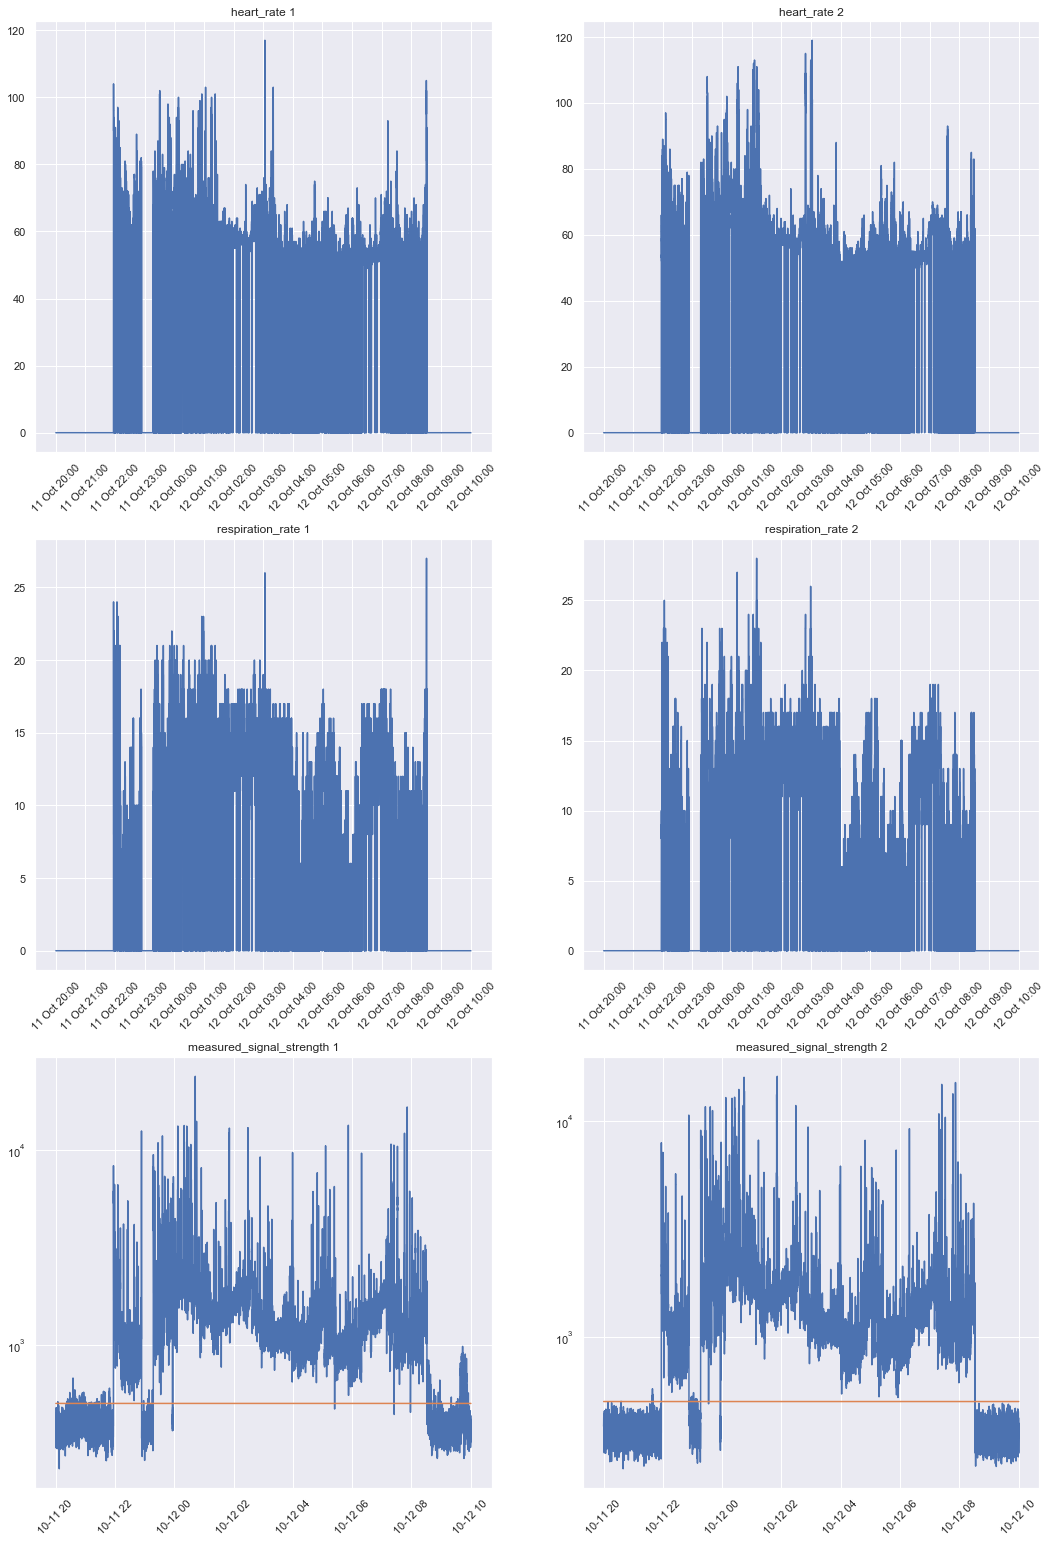

In [28]:
def compare_features(features, save=False):
    nbr_features = len(features)
    fig, axs = plt.subplots(nbr_features, 2, figsize=(18,9 * nbr_features))

    locator = mdates.HourLocator()
    formatter = mdates.DateFormatter('%d %b %H:%M')
    
    for i in (0, 1):
        for ax in axs[i]:
            ax.xaxis.set_major_formatter(formatter)
            ax.xaxis.set_major_locator(locator)
    
    x1 = df1.index
    x2 = df2.index
    xs = (x1, x2)
    dfs = (df1, df2)
    feature_dict = {}
    for i in (0, 1):
        feature_dict[i] = {}
        for feature in features:
            feature_dict[i][feature] = dfs[i][feature]
    
    for i in (0, 1):
        for j, (name, values) in enumerate(feature_dict[i].items()):
            axs[j][i].plot(xs[i], values)
            axs[j][i].xaxis.set_tick_params(rotation=45)
            axs[j][i].set_title(f'{name} {i+1}')
            if name == 'measured_signal_strength':
                axs[j][i].plot(xs[i], [THRESHOLD for _ in xs[i]])
                axs[j][i].set_yscale('log')
    if save:
        fig.savefig(IMAGES_DIR + 'ref_features_compare.png')

    plt.show()

compare_features(['heart_rate', 'respiration_rate', 'measured_signal_strength'], True)

Display forward fill

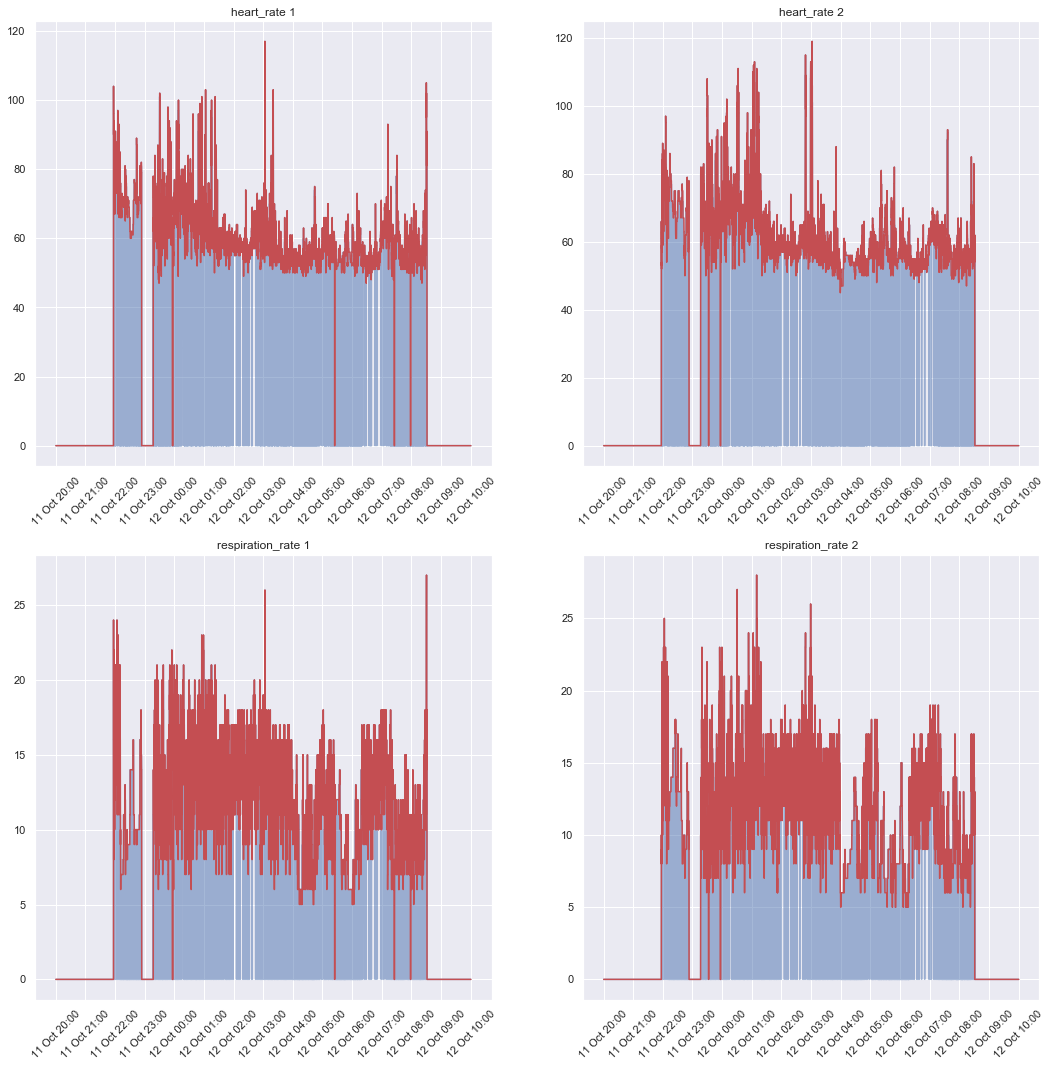

In [29]:
def display_ff(features, save=False):
    nbr_features = len(features)
    fig, axs = plt.subplots(nbr_features, 2, figsize=(18,9 * nbr_features))

    locator = mdates.HourLocator()
    formatter = mdates.DateFormatter('%d %b %H:%M')
    
    for i in (0, 1):
        for ax in axs[i]:
            ax.xaxis.set_major_formatter(formatter)
            ax.xaxis.set_major_locator(locator)
    
    x1 = df1.index
    x2 = df2.index
    xs = (x1, x2)
    dfs = (df1, df2)
    feature_dict = {}
    for i in (0, 1):
        feature_dict[i] = {}
        for feature in features:
            feature_dict[i][feature] = dfs[i][feature]
    
    for i in (0, 1):
        for j, (name, values) in enumerate(feature_dict[i].items()):
            axs[j][i].plot(xs[i], values, alpha=.5)
            axs[j][i].plot(xs[i], dfs[i][f'{name}_ff'], 'r-')
            axs[j][i].xaxis.set_tick_params(rotation=45)
            axs[j][i].set_title(f'{name} {i+1}')
        
    if save:
        fig.savefig(IMAGES_DIR + 'ref_features_forward_fill.png')

    plt.show()

display_ff(['heart_rate', 'respiration_rate'], True)

As we can clearly see above, most of the unwanted zero-values are now gone. Around 23:00 the proband was indeed not in the bed as the remaining (legit) zero-values illustrate.

Before we continue with the down sampling have a look at the vizualized similarity of the reference time series.
A rolling window approach with a window size of 600 (^= 10min) is used to do so.

/usr/local/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/usr/local/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


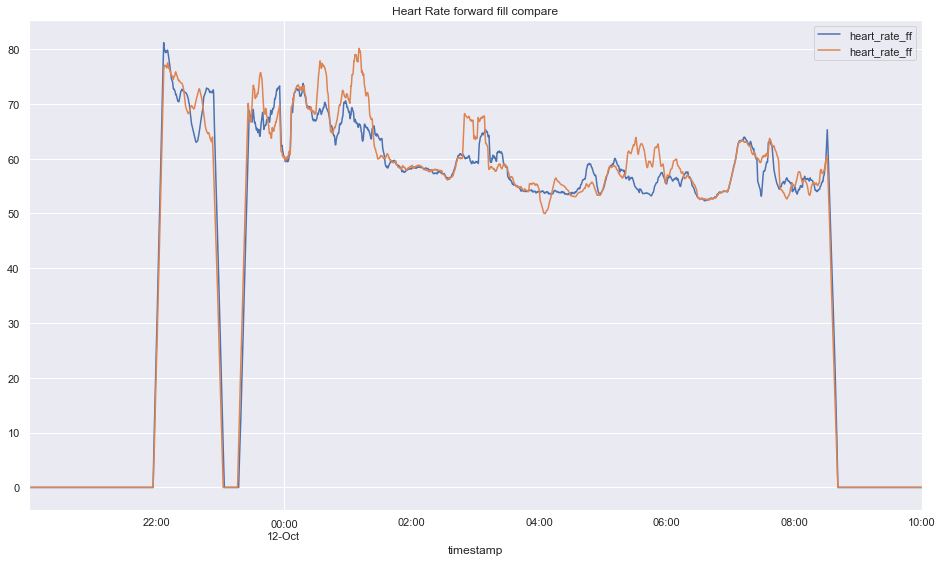

In [30]:
df1['heart_rate_ff'].rolling(600, min_periods=1).mean().plot(figsize=(16,9),
                                                            legend=True,
                                                            title="Heart Rate forward fill compare")
fig = df2['heart_rate_ff'].rolling(600, min_periods=1).mean().plot(legend=True).get_figure()
fig.savefig(IMAGES_DIR + 'ref_features_forward_fill_hr_compare.png')

/usr/local/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


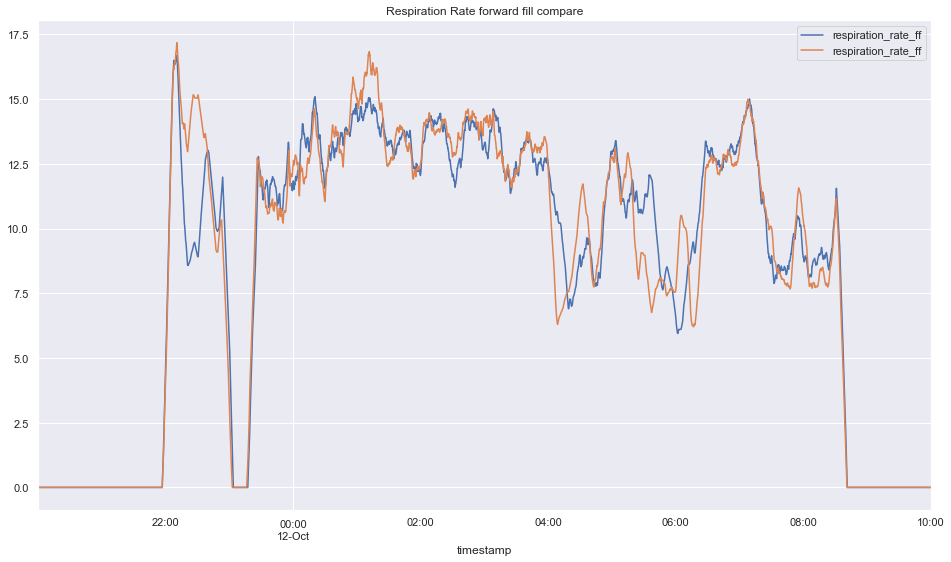

In [31]:
df1['respiration_rate_ff'].rolling(600, min_periods=1).mean().plot(figsize=(16,9),
                                                                   legend=True,
                                                                   title="Respiration Rate forward fill compare")
fig = df2['respiration_rate_ff'].rolling(600, min_periods=1).mean().plot(legend=True).get_figure()
fig.savefig(IMAGES_DIR + 'ref_features_forward_fill_rr_compare.png')

## Downsampling

The downsampling shall produce different granularities using resample approaches.

* 1 Hour
* 30 Minutes
* 5 Minutes
* 1 Minute

For each granularity a reference-csv file will be created containing the corresponding down-sampled values for df1 and df2

In [32]:
down_sample_df1 = df1.copy()
down_sample_df2 = df2.copy()

### 1 Hour granularity

In [33]:
df1_1hour = down_sample_df1[['heart_rate_ff', 'respiration_rate_ff']].resample('60Min').mean()
df1_1hour.columns = ['heart_rate_1', 'respiration_rate_1']

df2_1hour = down_sample_df2[['heart_rate_ff', 'respiration_rate_ff']].resample('60Min').mean()
df2_1hour.columns = ['heart_rate_2', 'respiration_rate_2']


In [34]:
df_1hour = pd.merge(df1_1hour, df2_1hour, how='left', on=['timestamp'])

In [35]:
df_1hour.head()

,heart_rate_1,respiration_rate_1,heart_rate_2,respiration_rate_2
timestamp,,,,
2020-10-11 20:00:00+00:00,0.000000,0.000000,0.000000,0.000000
2020-10-11 21:00:00+00:00,4.204167,0.731944,3.639444,0.661389
2020-10-11 22:00:00+00:00,64.477222,10.563056,62.617222,11.774444
2020-10-11 23:00:00+00:00,46.755556,8.228333,48.901389,8.349167
2020-10-12 00:00:00+00:00,68.876944,13.658611,71.012778,13.352222


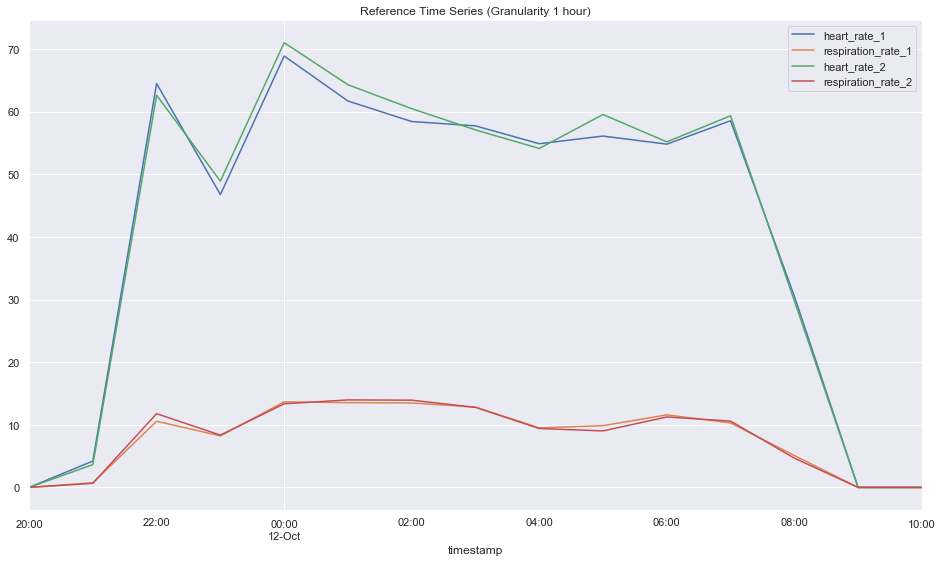

In [36]:
fig = df_1hour.plot(figsize=(16,9), 
                    legend=True,
                    title="Reference Time Series (Granularity 1 hour)").get_figure()
fig.savefig(IMAGES_DIR + 'ref_timeseries_1hour.png')

In [37]:
df_1hour.to_csv(REF_PATH_CLEAN + 'ref_1hour.csv')

### 30 minutes granularity

In [38]:
df1_30min = down_sample_df1[['heart_rate_ff', 'respiration_rate_ff']].resample('30Min').mean()
df1_30min.columns = ['heart_rate_1', 'respiration_rate_1']

df2_30min = down_sample_df2[['heart_rate_ff', 'respiration_rate_ff']].resample('30Min').mean()
df2_30min.columns = ['heart_rate_2', 'respiration_rate_2']

In [39]:
df_30min = pd.merge(df1_30min, df2_30min, how='left', on=['timestamp'])

In [40]:
df_30min.head()

,heart_rate_1,respiration_rate_1,heart_rate_2,respiration_rate_2
timestamp,,,,
2020-10-11 20:00:00+00:00,0.000000,0.000000,0.000000,0.000000
2020-10-11 20:30:00+00:00,0.000000,0.000000,0.000000,0.000000
2020-10-11 21:00:00+00:00,0.000000,0.000000,0.000000,0.000000
2020-10-11 21:30:00+00:00,8.408333,1.463889,7.278889,1.322778
2020-10-11 22:00:00+00:00,73.778333,11.526667,73.254444,15.025556


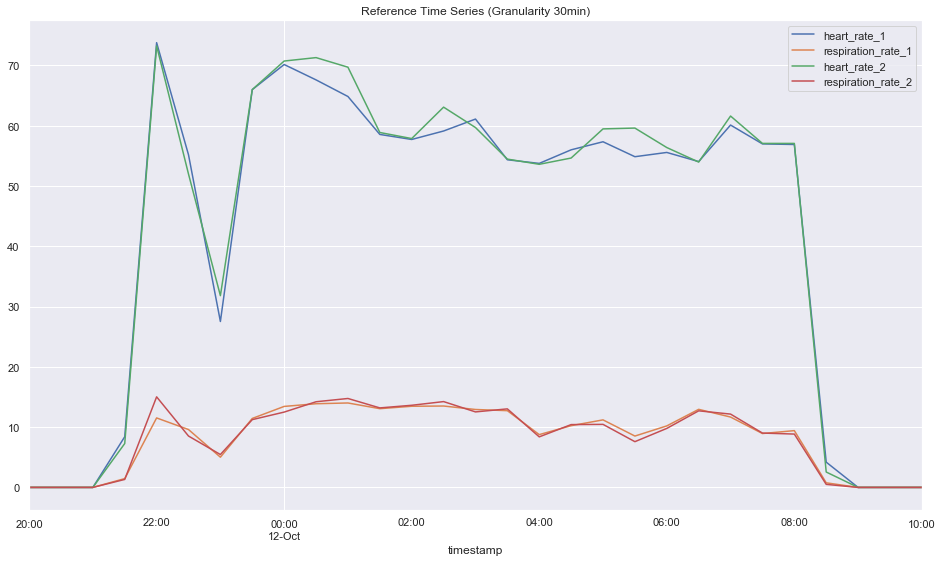

In [41]:
fig = df_30min.plot(figsize=(16,9), 
                    legend=True,
                    title="Reference Time Series (Granularity 30min)").get_figure()
fig.savefig(IMAGES_DIR + 'ref_timeseries_30min.png')

In [42]:
df_30min.to_csv(REF_PATH_CLEAN + 'ref_30min.csv')

### 5 minutes granularity


In [43]:
df1_5min = down_sample_df1[['heart_rate_ff', 'respiration_rate_ff']].resample('5Min').mean()
df1_5min.columns = ['heart_rate_1', 'respiration_rate_1']

df2_5min = down_sample_df2[['heart_rate_ff', 'respiration_rate_ff']].resample('5Min').mean()
df2_5min.columns = ['heart_rate_2', 'respiration_rate_2']

In [44]:
df_5min = pd.merge(df1_5min, df2_5min, how='left', on=['timestamp'])

In [45]:
df_5min.head()

,heart_rate_1,respiration_rate_1,heart_rate_2,respiration_rate_2
timestamp,,,,
2020-10-11 20:00:00+00:00,0.0,0.0,0.0,0.0
2020-10-11 20:05:00+00:00,0.0,0.0,0.0,0.0
2020-10-11 20:10:00+00:00,0.0,0.0,0.0,0.0
2020-10-11 20:15:00+00:00,0.0,0.0,0.0,0.0
2020-10-11 20:20:00+00:00,0.0,0.0,0.0,0.0


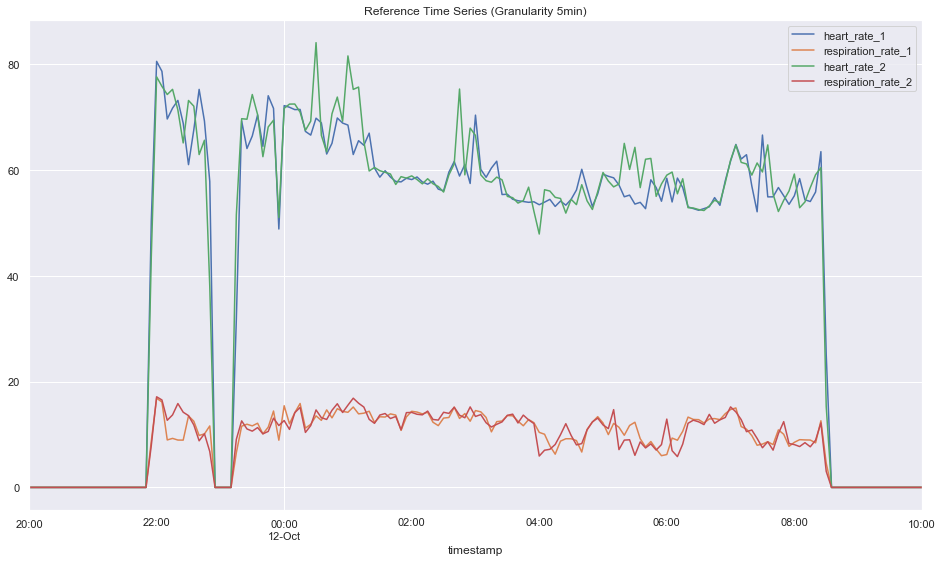

In [46]:
fig = df_5min.plot(figsize=(16,9), 
                    legend=True,
                    title="Reference Time Series (Granularity 5min)").get_figure()
fig.savefig(IMAGES_DIR + 'ref_timeseries_5min.png')

In [47]:
df_5min.to_csv(REF_PATH_CLEAN + 'ref_5min.csv')

### 1 minutes granularity


In [48]:
df1_1min = down_sample_df1[['heart_rate_ff', 'respiration_rate_ff']].resample('1Min').mean()
df1_1min.columns = ['heart_rate_1', 'respiration_rate_1']

df2_1min = down_sample_df2[['heart_rate_ff', 'respiration_rate_ff']].resample('1Min').mean()
df2_1min.columns = ['heart_rate_2', 'respiration_rate_2']

In [50]:
df_1min = pd.merge(df1_1min, df2_1min, how='left', on=['timestamp'])

In [51]:
df_1min.head()

,heart_rate_1,respiration_rate_1,heart_rate_2,respiration_rate_2
timestamp,,,,
2020-10-11 20:00:00+00:00,0.0,0.0,0.0,0.0
2020-10-11 20:01:00+00:00,0.0,0.0,0.0,0.0
2020-10-11 20:02:00+00:00,0.0,0.0,0.0,0.0
2020-10-11 20:03:00+00:00,0.0,0.0,0.0,0.0
2020-10-11 20:04:00+00:00,0.0,0.0,0.0,0.0


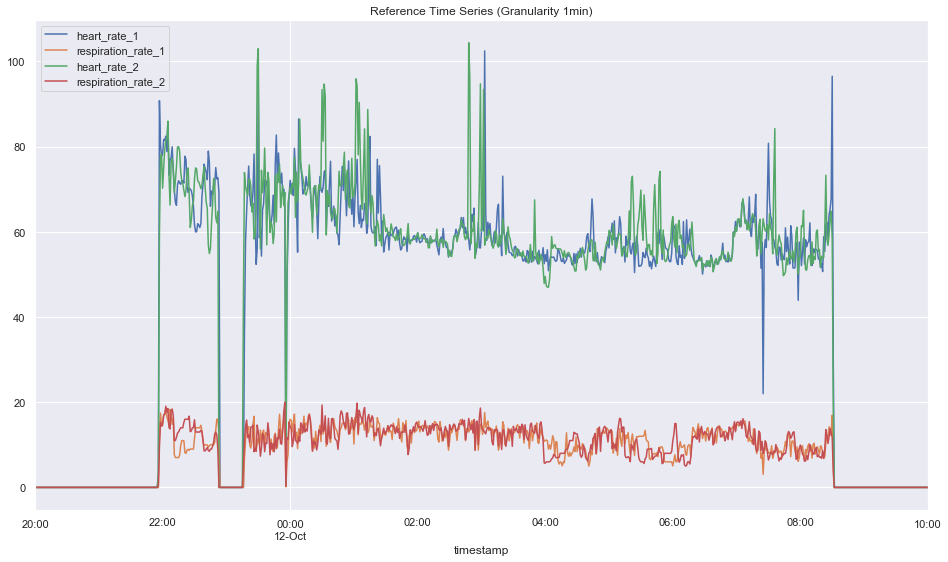

In [52]:
fig = df_1min.plot(figsize=(16,9), 
                    legend=True,
                    title="Reference Time Series (Granularity 1min)").get_figure()
fig.savefig(IMAGES_DIR + 'ref_timeseries_1min.png')

In [53]:
df_1min.to_csv(REF_PATH_CLEAN + 'ref_1min.csv')